# `mle-scheduler`: Lightweight Cluster/Cloud Job Scheduling 🚂
### Author: [@RobertTLange](https://twitter.com/RobertTLange) [Last Update: November 2021][![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RobertTLange/mle-scheduler/blob/main/examples/getting_started.ipynb)

I really dislike having to write Slurm job submission files. It is tedious, I always forget something and copying old templates feelds cumbersome. What if instead there was a tool that would completely get rid of this manual work? A tool that would schedule jobs on different cluster and cloud resources with a minimal and intuitive job/resource description? The `mle-scheduler` package aims to exactly provide such a service for Slurm, OpenGridEngine and Google Cloud Platform VMs. But you can also use the scheduling utilities to launch multiple training runs on a local machine or on a set of SSH servers. It comes with two core functional pillars:

- `MLEJob`: Launches and monitors a single job on a resource (Slurm, OpenGridEngine, GCP, etc.).
- `MLEQueue`: Launches and monitors a queue of jobs with different training configurations or random seeds.

![](https://github.com/mle-infrastructure/mle-scheduler/blob/main/docs/mle_scheduler_structure.png?raw=true)

In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

try:
    import mle_scheduler
except:
    !pip install -q mle-scheduler

Let's start by setting up a simple problem. In the code snippet below we "pseudo"-train a network for 10 epochs and log the training run statistics using [`mle-logging`](https://github.com/mle-infrastructure/mle-logging). I like it - but you can use whatever logging setup you prefer. Importantly, there are three command line arguments that are being parsed at the start-up: `experiment_dir` (the main log directory), `config_fname` (the configuration file to be loaded), `seed_id` (the random number seed for reproduction).

```python
from mle_logging import MLELogger, load_config


def main(experiment_dir: str, config_fname: str, seed_id: int):
    """Example training 'loop' using MLE-Logging."""
    train_config = load_config(config_fname)
    log = MLELogger(
        experiment_dir=experiment_dir,
        config_fname=config_fname,
        seed_id=seed_id,
        time_to_track=["num_epochs"],
        what_to_track=["train_loss", "test_loss"],
    )
    for epoch in range(1, 11):
        train_loss, test_loss = train_your_net(epoch, seed_id, **train_config)
        log.update(
            {"num_epochs": epoch},
            {"train_loss": train_loss, "test_loss": test_loss},
            save=True,
        )
        

if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Let's train a network.")
    parser.add_argument("-exp_dir", "--experiment_dir", type=str)
    parser.add_argument("-config", "--config_fname", type=str)
    parser.add_argument("-seed", "--seed_id", type=int, default=1)
    args = vars(parser.parse_args())
    main(args["experiment_dir"], args["config_fname"], args["seed_id"])
```

# Single Job Management with `MLEJob` 🚀

In [2]:
import logging
from mle_scheduler import MLEJob

# Launch a python train_mnist.py -config base_config.json job
job = MLEJob(resource_to_run="local",
             job_filename="train.py",
             config_filename="base_config_1.yaml",
             experiment_dir="logs_single",
             logger_level=logging.INFO)

job.run()

0

So how can you specify the resources that you would like to request/schedule for a job? This happens via the `job_arguments` option. It is a dictionary and depending on the resource you would like to run your job on, you have the following options: 

|| Local | SSH | Slurm           | SGE | GCP |
|----|----|------------ | ------------ | ----------- | --------------- |
|`env_name` | ✔️ | ✔️ | ✔️ | ✔️ | ❌

All SSH-server/cloud-based jobs also have their designated `cloud_settings` and `ssh_settings`. You can also manually monitor the status of the a scheduled job:

In [3]:
job_id = job.schedule()
while True:
    status = job.monitor(job_id)
    if status == 0:
        break

# Job Queue Management with `MLEQueue` 🚀🚀🚀

In [4]:
from mle_scheduler import MLEQueue

# Launch a queue of 4 jobs (2 configs x 2 seeds)
# python train.py -config base_config_1.yaml -seed 0 -exp_dir logs_queue/<date>_base_config_1
# python train.py -config base_config_1.yaml -seed 1 -exp_dir logs_queue/<date>_base_config_1
# python train.py -config base_config_2.yaml -seed 0 -exp_dir logs_queue/<date>_base_config_2
# python train.py -config base_config_2.yaml -seed 1 -exp_dir logs_queue/<date>_base_config_2
queue = MLEQueue(resource_to_run="local",
                 job_filename="train.py",
                 config_filenames=["base_config_1.yaml",
                                   "base_config_2.yaml"],
                 random_seeds=[0, 1],
                 experiment_dir="logs_queue")
queue.run()

100%|█████████████████████████████████████████████| 4/4 [00:02<00:00,  1.59it/s]        


You can also control how many jobs to schedule at a given point in time. E.g. if you don't want more than 10 jobs to be running/queued at a time simply add the `max_running_jobs` option:

In [5]:
queue = MLEQueue(resource_to_run="local",
                 job_filename="train.py",
                 config_filenames=["base_config_1.yaml",
                                   "base_config_2.yaml"],
                 random_seeds=[0, 1],
                 experiment_dir="logs_queue",
                 max_running_jobs=2)
queue.run()

100%|█████████████████████████████████████████████| 4/4 [00:05<00:00,  1.41s/it]        


# Slack Notification for Real-Time Queue Status

You can also get a Slack Bot notification of the current status of the queue. This is powered by the [`slack-clusterbot`](https://github.com/sprekelerlab/slack-clusterbot) package and you can follow these instructions to setup a bot for your favorite workspace [here](https://github.com/sprekelerlab/slack-clusterbot/wiki/Installation). After you have obtained your authentication token it is as simple as providing the token and your user name as inputs. Below you can find the slack chat output:

In [6]:
import os
queue = MLEQueue(resource_to_run="local",
                 job_filename="train.py",
                 config_filenames=["base_config_1.yaml",
                                   "base_config_2.yaml"],
                 random_seeds=[0, 1],
                 experiment_dir="logs_queue",
                 job_arguments={"env_name": "mle-toolbox"},
                 slack_user_name=os.environ["SLACK_USER_NAME"],
                 slack_auth_token=os.environ["SLACK_AUTH_TOKEN"])
queue.run()

100%|█████████████████████████████████████████████| 4/4 [00:03<00:00,  1.20it/s]        


![](https://github.com/mle-infrastructure/mle-scheduler/blob/main/docs/slackbot_output.png?raw=true)

# Automatic Log Merging & Plotting with `mle-logging`

The `mle-scheduler` is part of the broader `mle-infrastructure`. It therefore has some synergetic features with other packages such as the already mentioned `mle-logging` or `mle-hyperopt`. One of such features is automatic log aggregation after successful completion of all random seeds in `MLEQueue`. All you have to do is supply the option `automerge_seeds`: 

In [7]:
queue = MLEQueue(resource_to_run="local",
                 job_filename="train.py",
                 config_filenames=["base_config_1.yaml",
                                   "base_config_2.yaml"],
                 random_seeds=[0, 1],
                 experiment_dir="logs_merge",
                 automerge_seeds=True)
queue.run()

100%|█████████████████████████████████████████████| 4/4 [00:03<00:00,  1.18it/s]        


You can then easily load and visualize the results as follows:

(<Figure size 648x432 with 1 Axes>,
 <AxesSubplot:title={'center':'train_loss, test_loss'}, xlabel='num_epochs', ylabel='train_loss, test_loss'>)

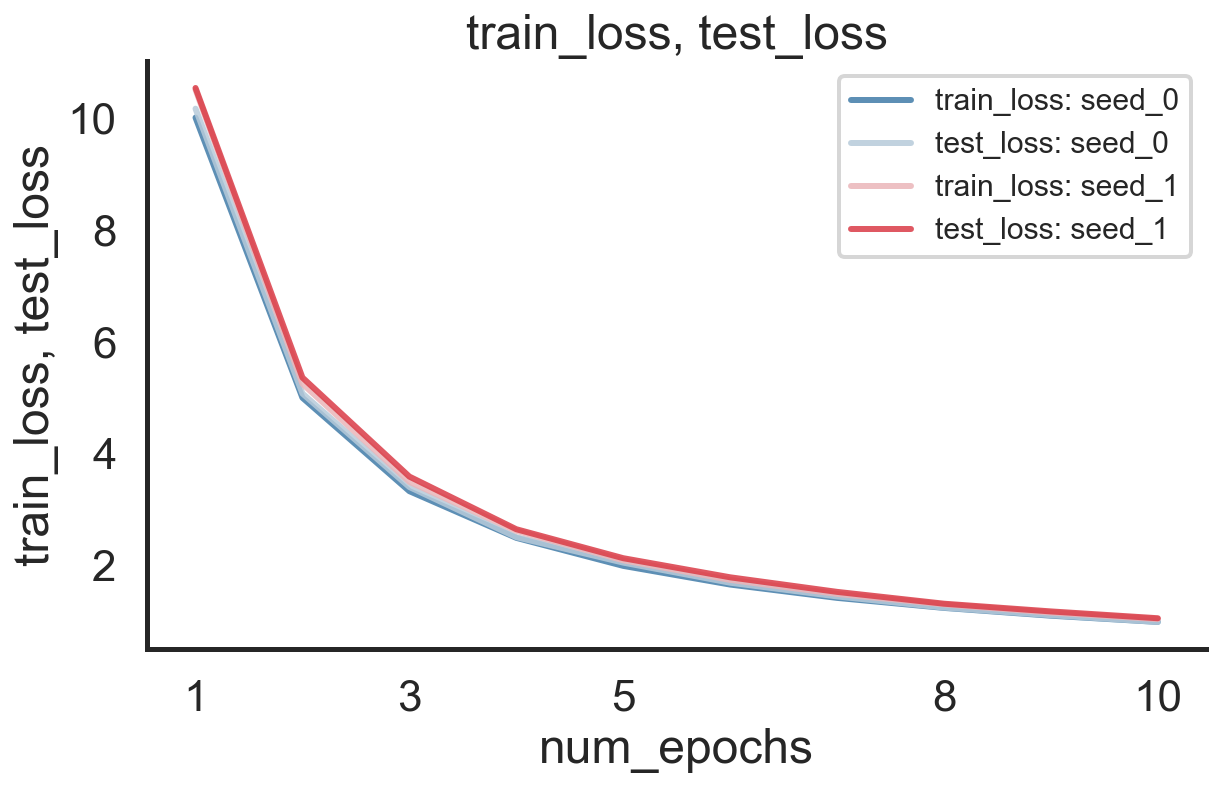

In [8]:
from mle_logging import load_log
import datetime
date = datetime.datetime.today().strftime("%Y-%m-%d")[2:]
log = load_log(f"logs_merge/{date}_base_config_1")
log.plot(["train_loss", "test_loss"])

# Search Jobs with `mle-hyperopt` Configurations

Finally, `mle-scheduler` integrates smoothly with the hyperparameter search tool `mle-hyperopt`. After defining a search strategy, `mle-hyperopt` allows us to get a set of candidate hyperparameters and to export them as configuration files in one go:

In [9]:
try:
    import mle_hyperopt
except:
    !pip install -q mle-hyperopt
    import mle_hyperopt

from mle_hyperopt import RandomSearch

# Instantiate random search class
strategy = RandomSearch(real={"lrate": {"begin": 0.1,
                                        "end": 0.5,
                                        "prior": "log-uniform"}},
                        integer={"batch_size": {"begin": 1,
                                                "end": 5,
                                                "prior": "uniform"}},
                        categorical={"arch": ["mlp", "cnn"]})

# Simple ask - eval - tell API
configs, config_fnames = strategy.ask(2, store=True)
config_fnames

['eval_0.yaml', 'eval_1.yaml']

Next we simply forward the configuration filenames to the `MLEQueue` and voilà we have a batch of search configurations running:

In [10]:
queue = MLEQueue(resource_to_run="local",
                 job_filename="train.py",
                 config_filenames=config_fnames,
                 experiment_dir="logs_search")
queue.run()

100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.04s/it]        


# Launching an SSH Job & a Queue

In [11]:
from mle_scheduler.ssh.manage_ssh import send_code_ssh, copy_results_ssh, clean_up_ssh

ssh_settings = {"user_name":"RobTLange",
                "pkey_path": '~.ssh/id_rsa',
                "main_server": 'cluster.ml.tu-berlin.de',
                "jump_server": '',
                "ssh_port": 22,
                "remote_dir": "mle-code-dir",
                "start_up_copy_dir": True, 
                "clean_up_remote_dir": True}

# scp the current working directory to a mle-code-dir remote
send_code_ssh(ssh_settings)

In [12]:
job = MLEJob(resource_to_run="ssh-node",
             job_filename="train.py",
             config_filename="base_config_1.yaml",
             experiment_dir="logs_ssh_single",
             job_arguments={"env_name": "mle-toolbox"},
             ssh_settings=ssh_settings,
             logger_level=logging.INFO)

job.run()

0

In [13]:
# Copy over the results from the SSH server
copy_results_ssh(ssh_settings, remote_dir="mle-code-dir/logs_ssh_single")
# Delete the code directory on the SSH server
clean_up_ssh(ssh_settings)

2021-11-09 13:58:12,126| ERROR   | Could not establish connection from local ('127.0.0.1', 58697) to remote ('cluster.ml.tu-berlin.de', 22) side of the tunnel: 


In [14]:
ssh_settings = {"user_name":"RobTLange",
                "pkey_path": '~.ssh/id_rsa',
                "main_server": 'cluster.ml.tu-berlin.de',
                "jump_server": '',
                "ssh_port": 22,
                "remote_dir": "mle-code-dir",
                "start_up_copy_dir": True, 
                "clean_up_remote_dir": True}
queue = MLEQueue(resource_to_run="ssh-node",
                 job_filename="train.py",
                 config_filenames=["base_config_1.yaml",
                                   "base_config_2.yaml"],
                 random_seeds=[0, 1],
                 experiment_dir="logs_ssh_queue",
                 job_arguments={"env_name": "mle-toolbox"},
                 ssh_settings=ssh_settings)

queue.run()

2021-11-09 13:58:32,008| ERROR   | Could not establish connection from local ('127.0.0.1', 58706) to remote ('cluster.ml.tu-berlin.de', 22) side of the tunnel: 
2021-11-09 13:58:46,754| ERROR   | Could not establish connection from local ('127.0.0.1', 58717) to remote ('cluster.ml.tu-berlin.de', 22) side of the tunnel: 
100%|█████████████████████████████████████████████| 4/4 [00:21<00:00,  5.26s/it]        
2021-11-09 13:59:21,752| ERROR   | Could not establish connection from local ('127.0.0.1', 58736) to remote ('cluster.ml.tu-berlin.de', 22) side of the tunnel: 
